# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization (TBD)

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

The process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

The process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$ , that is, the impact $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in a data in X.


## T
Labels for X. There are two formats available for the label.

#### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

#### Index labels

The label ```t``` is specified as ```t = 2```. 

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Use the row-order matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from common import (
    xavier,
    he,
    uniform
)
from layer.matmul import Matmul

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Batch Normalization Layer

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

---

# Activation layer

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == TYPE_FLOAT), \
        "X must be float or ndarray(dtype=TYPE_FLOAT)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    # exp = np.exp(X - C)
    exp = ne.evaluate("exp(X - C)")
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Backward path

### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [9]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [12]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [13]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[ 1.68850136  2.88357476]
 [-0.53086517  0.38070628]]

Analytical gradient:
[[0.84402697 0.94702848]
 [0.37031512 0.59404344]]

Numerical gradient:
[[0.84402707 0.94702912]
 [0.37031267 0.59404037]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [14]:
%reload_ext autoreload
%autoreload 2
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [15]:
N = 500    # Number of plots
D = 2      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
_X = np.c_[
    np.ones(N),     # Bias
    X
]
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


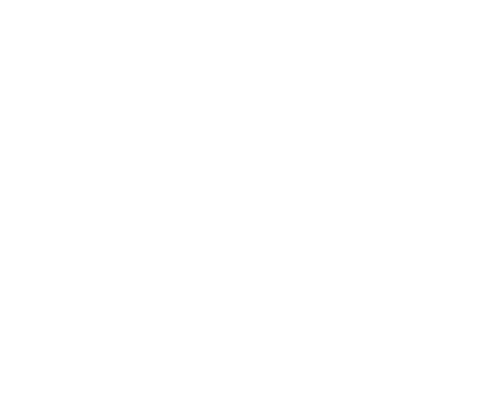

In [16]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 0], X[T==0, 1], c='red')
ax.scatter(X[T==1, 0], X[T==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [17]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## Sigmoid classifier training


<IPython.core.display.Javascript object>


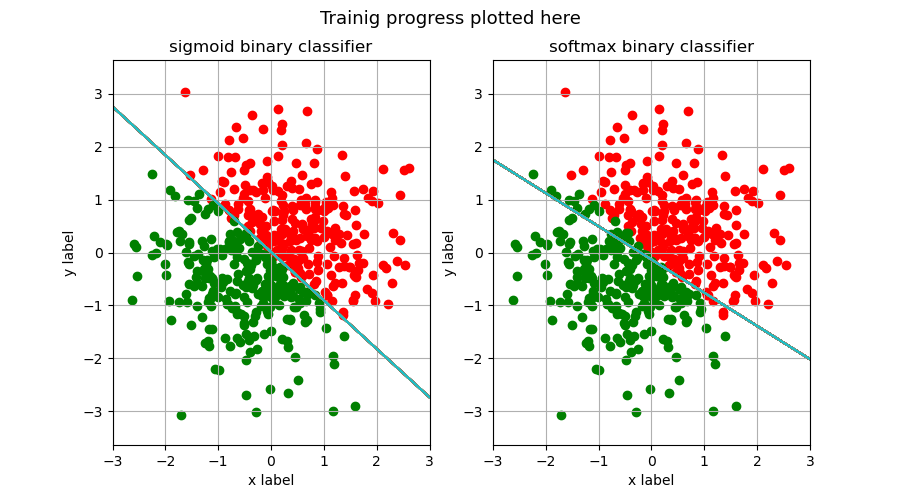

Train a sigmoid classifier to find optimal W (-0.01609419497965947, -0.663566583324153, -0.7479440930868206) for the boundary.
iteration 0 Loss 1.0096055122054997


array([[ 0.01791031, -1.53565721, -1.67508762]])

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 0], X[T==0, 1], c='red')
    ax[i].scatter(X[T==1, 0], X[T==1, 1], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")




print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 50

M = 1
W = weights.xavier(M, D+1)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

In [19]:
%lprun \
    -T train_sigmoid_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=sigmoid_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_sigmoid_classifier.log', 'r').read())

iteration 0 Loss 0.230114145995528

*** Profile printout saved to text file 'train_sigmoid_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 1.12744 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56                                                   o

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [20]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 2                      
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (-0.01609419497965947, -0.663566583324153, -0.7479440930868206) for the boundary.
iteration 0 Loss 0.8760675972972022
iteration 50 Loss 0.17135376771564


array([[ 0.21485271,  1.01357899,  1.61189432],
       [ 0.16324916, -1.86365448, -1.59226726]])

In [21]:
%lprun \
    -T train_softmax_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=softmax_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_softmax_classifier.log', 'r').read())

iteration 0 Loss 0.1319389568719784
iteration 50 Loss 0.113675077725044

*** Profile printout saved to text file 'train_softmax_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 2.33835 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56               

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [22]:
%reload_ext autoreload
%autoreload 2
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [23]:
print(f"Train a categorical classifier")
N = 300
D = 2      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


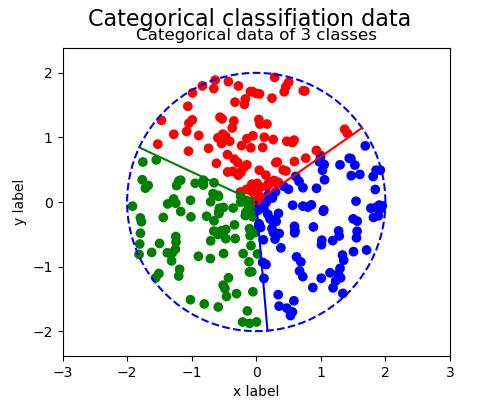

In [24]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,0], X[::,1], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [25]:
MAX_TEST_TIMES = 2000
W = weights.he(M, D+1)
optimizer = SGD(lr=0.5)

train_matmul_relu_classifier
# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[-0.0139924   0.09525489 -0.1067691 ]
 [ 0.02598453 -0.01438813  0.03965853]
 [-0.14483512 -0.1679465   0.04356934]]
Diff
[[-0.00655785 -0.01344556  0.00615195]
 [-0.0016821   0.00067816 -0.00274474]
 [ 0.01387829  0.01645554 -0.00612102]]


iteration 0 Loss 1.0529334716643923
iteration 50 Loss 0.6312988271994224
iteration 100 Loss 0.5882507985818781
iteration 150 Loss 0.5651481223181054
iteration 200 Loss 0.5497139497388491
iteration 250 Loss 0.5378265596694127
iteration 300 Loss 0.5282926854398043
iteration 350 Loss 0.5203692953020309
iteration 400 Loss 0.5136404279011418
iteration 450 Loss 0.507968311263737
iteration 500 Loss 0.5030649264546979
iteration 550 Loss 0.4988090872509892
iteration 600 Loss 0.4950543056413113
iteration 650 Loss 0.4916582905706423
iteration 700 Loss 0.48855573408087605
iteration 750 Loss 0.48567570204789057
iteration 800 Loss 0.4830615352869317
iteration 850 Loss 0.4807072375800947
iteration 900 Loss 0.4785382603354761
iteration 950 Loss 0.4765184449335199
iteration 1000 Loss 0.47464547184251205
iteration 1050 Loss 0.47292345551860004
iteration 1100 Loss 0.4713167936700497
iteration 1150 Loss 0.4698011045677116
iteration 1200 Loss 0.4683833099093645
iteration 1250 Loss 0.4670362066295661
iterat

### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


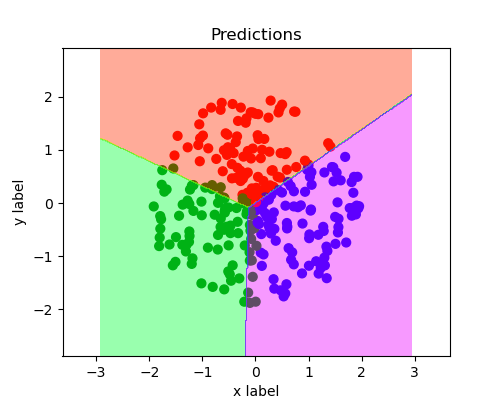

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [26]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Non-linearly separable data

In [27]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


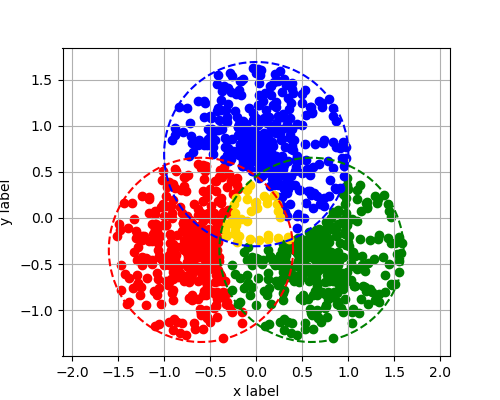

In [34]:
__M = 3        # Number of circles
__N = 500
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [35]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]


print(f"X:{X.shape} T:{T.shape} ")

X:(1200, 2) T:(1200,) 


### Train on non-linear separable data

In [37]:
MAX_TEST_TIMES = 50000
D = 2
M1 = 8
W1 = weights.he(M1, D+1)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1+1)
optimizer = SGD(lr=0.5)

X, T = transform_X_T(X, T)
W1, W2, objective, prediction = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.3349818033462255
iteration 100 Loss 0.1697591026383747
iteration 200 Loss 0.14840363974706008
iteration 300 Loss 0.1371157337531383
iteration 400 Loss 0.12975148938941472
iteration 500 Loss 0.12442474925077181
iteration 600 Loss 0.12006427147230665
iteration 700 Loss 0.11651421584389737
iteration 800 Loss 0.11312801674010596
iteration 900 Loss 0.10941217742540049
iteration 1000 Loss 0.10591811322266748
iteration 1100 Loss 0.10322745636295194
iteration 1200 Loss 0.10084681603924843
iteration 1300 Loss 0.09857184410922763
iteration 1400 Loss 0.09641513859149692
iteration 1500 Loss 0.09436901629423358
iteration 1600 Loss 0.09241855627327791
iteration 1700 Loss 0.09056779738004694
iteration 1800 Loss 0.08881854783720622
iteration 1900 Loss 0.08718587897941249
iteration 2000 Loss 0.08561261896954392
iteration 2100 Loss 0.08409705728793561
iteration 2200 Loss 0.08266159911795654
iteration 2300 Loss 0.08132335400134841
iteration 2400 Loss 0.08009050128642822
iteration 2500 

Iteration [8333]: Loss[0.05673954855751809] has not improved from the previous [0.056739506210845135] for 1 times.


iteration 8300 Loss 0.056783887681657944


Iteration [8417]: Loss[0.056634534032134656] has not improved from the previous [0.05663444672178852] for 1 times.


iteration 8400 Loss 0.056654636221103824
iteration 8500 Loss 0.05654232993161614
iteration 8600 Loss 0.05643482711330172
iteration 8700 Loss 0.05632915115330655
iteration 8800 Loss 0.056225799546760866
iteration 8900 Loss 0.056124238020109386
iteration 9000 Loss 0.056024185828558115
iteration 9100 Loss 0.055926885771125555
iteration 9200 Loss 0.05583060914648145


Iteration [9309]: Loss[0.055728981447249394] has not improved from the previous [0.05572872032047787] for 1 times.


iteration 9300 Loss 0.05573594523327735


Iteration [9337]: Loss[0.05570531693590299] has not improved from the previous [0.05570510005104539] for 1 times.
Iteration [9364]: Loss[0.0556848607914902] has not improved from the previous [0.0556846787565082] for 1 times.
Iteration [9375]: Loss[0.05567733681635213] has not improved from the previous [0.05567722450535411] for 1 times.


iteration 9400 Loss 0.05566221634248777


Iteration [9458]: Loss[0.055627215015168686] has not improved from the previous [0.05562718955172794] for 1 times.
Iteration [9534]: Loss[0.05558638523516846] has not improved from the previous [0.055586095476362625] for 1 times.


iteration 9500 Loss 0.055604404003576774
iteration 9600 Loss 0.055553990944142734


Iteration [9700]: Loss[0.05550671838743496] has not improved from the previous [0.055506603628179815] for 1 times.


iteration 9700 Loss 0.05550671838743496


Iteration [9773]: Loss[0.05547563979442335] has not improved from the previous [0.055475594446961006] for 1 times.
Iteration [9833]: Loss[0.05545260496369551] has not improved from the previous [0.05545257713515589] for 1 times.


iteration 9800 Loss 0.05546477732814274


Iteration [9878]: Loss[0.05543710080160519] has not improved from the previous [0.05543709435716646] for 1 times.
Iteration [9888]: Loss[0.05543409396806716] has not improved from the previous [0.055433904902626334] for 1 times.
Iteration [9910]: Loss[0.05542781713257369] has not improved from the previous [0.05542776482723892] for 1 times.


iteration 9900 Loss 0.055430376267779406


Iteration [9937]: Loss[0.0554209819752003] has not improved from the previous [0.05542093664290625] for 1 times.
Iteration [9940]: Loss[0.055420235980314626] has not improved from the previous [0.05542019175456158] for 1 times.
Iteration [9968]: Loss[0.05541452201694039] has not improved from the previous [0.055414521492707806] for 1 times.
Iteration [9977]: Loss[0.05541288632902439] has not improved from the previous [0.05541279165173413] for 1 times.


iteration 10000 Loss 0.05540888318482402


Iteration [10034]: Loss[0.055403380628696514] has not improved from the previous [0.05540332971812841] for 1 times.
Iteration [10086]: Loss[0.05539557590886357] has not improved from the previous [0.05539552958791748] for 1 times.
Iteration [10098]: Loss[0.055393903526040185] has not improved from the previous [0.05539388543001891] for 1 times.
Iteration [10116]: Loss[0.05539174035668778] has not improved from the previous [0.0553917098587479] for 1 times.


iteration 10100 Loss 0.0553935396211571


Iteration [10125]: Loss[0.05539070677823774] has not improved from the previous [0.0553906900996566] for 1 times.
Iteration [10128]: Loss[0.055390377178805794] has not improved from the previous [0.0553903722515887] for 1 times.
Iteration [10155]: Loss[0.055387996791205936] has not improved from the previous [0.055387948639535195] for 1 times.
Iteration [10182]: Loss[0.05538578879923725] has not improved from the previous [0.05538578662043155] for 1 times.
Iteration [10194]: Loss[0.05538491075212216] has not improved from the previous [0.05538488780841547] for 1 times.


iteration 10200 Loss 0.05538446215641308


Iteration [10224]: Loss[0.05538294391579811] has not improved from the previous [0.055382907548956146] for 1 times.
Iteration [10233]: Loss[0.05538237955543884] has not improved from the previous [0.055382373864935344] for 1 times.
Iteration [10236]: Loss[0.05538220275020817] has not improved from the previous [0.05538219960089119] for 1 times.
Iteration [10263]: Loss[0.05538091863336798] has not improved from the previous [0.05538089013154973] for 1 times.
Iteration [10275]: Loss[0.05538036998235083] has not improved from the previous [0.0553803693001593] for 1 times.
Iteration [10302]: Loss[0.05537931511331519] has not improved from the previous [0.055379312415563445] for 1 times.
Iteration [10314]: Loss[0.05537888163433687] has not improved from the previous [0.05537887666770529] for 1 times.


iteration 10300 Loss 0.055379370972215354


Iteration [10356]: Loss[0.05537753953643188] has not improved from the previous [0.05537753420085136] for 1 times.
Iteration [10373]: Loss[0.05537704573263466] has not improved from the previous [0.05537703691318348] for 1 times.


iteration 10400 Loss 0.055376331202740034


Iteration [10437]: Loss[0.05537538540780224] has not improved from the previous [0.05537537487897771] for 1 times.
Iteration [10454]: Loss[0.05537497746767587] has not improved from the previous [0.05537497651310214] for 1 times.
Iteration [10466]: Loss[0.05537471821284174] has not improved from the previous [0.055374716550042793] for 1 times.
Iteration [10481]: Loss[0.05537442694335199] has not improved from the previous [0.055374426507155995] for 1 times.
Iteration [10496]: Loss[0.05537417488656189] has not improved from the previous [0.055374161693891824] for 1 times.


iteration 10500 Loss 0.05537409199339238


Iteration [10547]: Loss[0.05537337430893476] has not improved from the previous [0.055373372094220094] for 1 times.
Iteration [10555]: Loss[0.0553732595795875] has not improved from the previous [0.05537325682509985] for 1 times.
Iteration [10589]: Loss[0.05537282882379257] has not improved from the previous [0.055372823718977456] for 1 times.


iteration 10600 Loss 0.055372687695464315


Iteration [10633]: Loss[0.05537232203263048] has not improved from the previous [0.05537232072698442] for 1 times.
Iteration [10648]: Loss[0.055372166940828624] has not improved from the previous [0.0553721640200163] for 1 times.
Iteration [10660]: Loss[0.05537204988191714] has not improved from the previous [0.055372049760226597] for 1 times.
Iteration [10699]: Loss[0.05537172333765556] has not improved from the previous [0.05537172301143663] for 1 times.


iteration 10700 Loss 0.05537170815641578


Iteration [10716]: Loss[0.0553715935327946] has not improved from the previous [0.05537159331697929] for 1 times.
Iteration [10770]: Loss[0.05537122446459473] has not improved from the previous [0.05537122333257594] for 1 times.


iteration 10800 Loss 0.05537103506407528


Iteration [10829]: Loss[0.055370859900683744] has not improved from the previous [0.0553708587767692] for 1 times.
Iteration [10880]: Loss[0.055370575247755245] has not improved from the previous [0.055370572909289456] for 1 times.
Iteration [10897]: Loss[0.055370488119359525] has not improved from the previous [0.05537048776745789] for 1 times.


iteration 10900 Loss 0.05537047149111919


Iteration [10951]: Loss[0.0553702427866126] has not improved from the previous [0.0553702421807278] for 1 times.
Iteration [11010]: Loss[0.05537000091227137] has not improved from the previous [0.05537000069342518] for 1 times.


iteration 11000 Loss 0.0553700394544124


Iteration [11049]: Loss[0.05536985627011732] has not improved from the previous [0.05536985585767206] for 1 times.
Iteration [11061]: Loss[0.055369815578290606] has not improved from the previous [0.05536981473617164] for 1 times.
Iteration [11103]: Loss[0.05536968881049855] has not improved from the previous [0.05536968870049011] for 1 times.


iteration 11100 Loss 0.055369696737067396


Iteration [11120]: Loss[0.05536964206069533] has not improved from the previous [0.05536964187268469] for 1 times.
Iteration [11147]: Loss[0.05536957550540407] has not improved from the previous [0.05536957550075516] for 1 times.
Iteration [11162]: Loss[0.0553695421281015] has not improved from the previous [0.05536954129715517] for 1 times.
Iteration [11174]: Loss[0.055369517811991203] has not improved from the previous [0.05536951711762793] for 1 times.


iteration 11200 Loss 0.05536946952440134


Iteration [11233]: Loss[0.055369411114649006] has not improved from the previous [0.05536941098817746] for 1 times.
Iteration [11275]: Loss[0.05536934289568627] has not improved from the previous [0.05536934283393791] for 1 times.
Iteration [11284]: Loss[0.0553693295621414] has not improved from the previous [0.05536932931355672] for 1 times.
Iteration [11287]: Loss[0.05536932499017137] has not improved from the previous [0.05536932494458721] for 1 times.
Iteration [11326]: Loss[0.05536927822703612] has not improved from the previous [0.05536927813526141] for 1 times.


iteration 11300 Loss 0.05536930898103688


Iteration [11368]: Loss[0.05536923293073499] has not improved from the previous [0.055369232921531904] for 1 times.
Iteration [11385]: Loss[0.055369216389858034] has not improved from the previous [0.055369216310822415] for 1 times.


iteration 11400 Loss 0.05536920275212253


Iteration [11439]: Loss[0.05536916864510298] has not improved from the previous [0.05536916855877296] for 1 times.
Iteration [11456]: Loss[0.05536915515569885] has not improved from the previous [0.05536915489697673] for 1 times.
Iteration [11510]: Loss[0.055369116341706784] has not improved from the previous [0.05536911628228917] for 1 times.


iteration 11500 Loss 0.055369123182713066


Iteration [11569]: Loss[0.05536907831667048] has not improved from the previous [0.05536907803041191] for 1 times.
Iteration [11578]: Loss[0.05536907280248146] has not improved from the previous [0.05536907276770657] for 1 times.
Iteration [11608]: Loss[0.05536905690087155] has not improved from the previous [0.05536905686541041] for 1 times.
Iteration [11620]: Loss[0.055369051235221144] has not improved from the previous [0.0553690511895095] for 1 times.


iteration 11600 Loss 0.05536906074575434


Iteration [11662]: Loss[0.05536903319161246] has not improved from the previous [0.05536903311382095] for 1 times.
Iteration [11674]: Loss[0.055369028413889604] has not improved from the previous [0.05536902838946036] for 1 times.
Iteration [11691]: Loss[0.055369022545221504] has not improved from the previous [0.0553690223541634] for 1 times.


iteration 11700 Loss 0.055369019489653795


Iteration [11725]: Loss[0.05536901174711266] has not improved from the previous [0.055369011687368054] for 1 times.
Iteration [11754]: Loss[0.05536900340086097] has not improved from the previous [0.05536900339413606] for 1 times.
Iteration [11796]: Loss[0.05536899263399384] has not improved from the previous [0.05536899258059629] for 1 times.
Iteration [11801]: Loss[0.05536899144946736] has not improved from the previous [0.05536899141078841] for 1 times.
Iteration [11813]: Loss[0.05536898889254359] has not improved from the previous [0.05536898884209684] for 1 times.


iteration 11800 Loss 0.05536899141078841


Iteration [11843]: Loss[0.05536898320734956] has not improved from the previous [0.055368983190436795] for 1 times.
Iteration [11855]: Loss[0.05536898113617447] has not improved from the previous [0.05536898109693535] for 1 times.
Iteration [11872]: Loss[0.0553689784781542] has not improved from the previous [0.05536897845036528] for 1 times.
Iteration [11894]: Loss[0.055368975438078075] has not improved from the previous [0.05536897541091142] for 1 times.
Iteration [11923]: Loss[0.055368971778456524] has not improved from the previous [0.05536897177401151] for 1 times.


iteration 11900 Loss 0.05536897453426538


Iteration [11953]: Loss[0.05536896838352843] has not improved from the previous [0.05536896836315269] for 1 times.
Iteration [11965]: Loss[0.05536896713320571] has not improved from the previous [0.05536896711995478] for 1 times.
Iteration [11982]: Loss[0.05536896556103071] has not improved from the previous [0.05536896553407849] for 1 times.


iteration 12000 Loss 0.05536896401277757


Iteration [12036]: Loss[0.05536896106544577] has not improved from the previous [0.05536896106421604] for 1 times.
Iteration [12095]: Loss[0.055368956647507114] has not improved from the previous [0.05536895663566887] for 1 times.
Iteration [12107]: Loss[0.05536895580132639] has not improved from the previous [0.055368955790044555] for 1 times.


iteration 12100 Loss 0.05536895624613309


Iteration [12146]: Loss[0.055368953418791486] has not improved from the previous [0.05536895341664858] for 1 times.
Iteration [12217]: Loss[0.05536894952053148] has not improved from the previous [0.05536894950612589] for 1 times.


iteration 12200 Loss 0.055368950448547886


Iteration [12247]: Loss[0.055368948018779764] has not improved from the previous [0.05536894801872783] for 1 times.
Iteration [12276]: Loss[0.05536894671893985] has not improved from the previous [0.05536894670127359] for 1 times.
Iteration [12318]: Loss[0.055368945004389616] has not improved from the previous [0.0553689450010129] for 1 times.


iteration 12300 Loss 0.05536894570376745


Iteration [12330]: Loss[0.05536894455987646] has not improved from the previous [0.055368944559695536] for 1 times.
Iteration [12360]: Loss[0.05536894356636266] has not improved from the previous [0.055368943564467914] for 1 times.


iteration 12400 Loss 0.055368942333331374


Iteration [12440]: Loss[0.055368941185429205] has not improved from the previous [0.05536894118004078] for 1 times.
Iteration [12482]: Loss[0.05536894005290211] has not improved from the previous [0.05536894005179472] for 1 times.
Iteration [12499]: Loss[0.05536893963988294] has not improved from the previous [0.0553689396395939] for 1 times.
Iteration [12523]: Loss[0.05536893910406132] has not improved from the previous [0.05536893910370059] for 1 times.


iteration 12500 Loss 0.05536893959291015


Iteration [12541]: Loss[0.05536893875038179] has not improved from the previous [0.05536893874908617] for 1 times.
Iteration [12604]: Loss[0.05536893762600014] has not improved from the previous [0.05536893762525215] for 1 times.
Iteration [12621]: Loss[0.05536893734673225] has not improved from the previous [0.05536893734654062] for 1 times.


iteration 12600 Loss 0.05536893769206267


Iteration [12633]: Loss[0.05536893717453418] has not improved from the previous [0.05536893717202299] for 1 times.
Iteration [12645]: Loss[0.055368937012000546] has not improved from the previous [0.05536893701197876] for 1 times.
Iteration [12675]: Loss[0.055368936659738445] has not improved from the previous [0.055368936656354534] for 1 times.
Iteration [12687]: Loss[0.05536893652925727] has not improved from the previous [0.05536893652664978] for 1 times.
Iteration [12704]: Loss[0.05536893636175705] has not improved from the previous [0.055368936361442814] for 1 times.


iteration 12700 Loss 0.055368936395878615


Iteration [12738]: Loss[0.05536893606791845] has not improved from the previous [0.05536893606554289] for 1 times.
Iteration [12767]: Loss[0.05536893583913316] has not improved from the previous [0.055368935837026276] for 1 times.
Iteration [12809]: Loss[0.05536893554141045] has not improved from the previous [0.055368935539049806] for 1 times.


iteration 12800 Loss 0.05536893560060671


Iteration [12826]: Loss[0.0553689354303998] has not improved from the previous [0.055368935429831935] for 1 times.
Iteration [12880]: Loss[0.0553689351195245] has not improved from the previous [0.055368935118126475] for 1 times.
Iteration [12889]: Loss[0.055368935071281274] has not improved from the previous [0.055368935071185704] for 1 times.
Iteration [12892]: Loss[0.05536893505545278] has not improved from the previous [0.05536893505532395] for 1 times.


iteration 12900 Loss 0.05536893501715528


Iteration [12931]: Loss[0.055368934889923976] has not improved from the previous [0.05536893488967242] for 1 times.
Iteration [12948]: Loss[0.05536893482459279] has not improved from the previous [0.05536893482441721] for 1 times.
Iteration [13002]: Loss[0.055368934638624766] has not improved from the previous [0.055368934637623185] for 1 times.


iteration 13000 Loss 0.05536893464250453


Iteration [13014]: Loss[0.05536893460016015] has not improved from the previous [0.055368934599503185] for 1 times.
Iteration [13044]: Loss[0.055368934515496813] has not improved from the previous [0.05536893451549522] for 1 times.
Iteration [13056]: Loss[0.055368934484628804] has not improved from the previous [0.0553689344844841] for 1 times.
Iteration [13073]: Loss[0.05536893444488086] has not improved from the previous [0.05536893444486707] for 1 times.
Iteration [13098]: Loss[0.05536893439370568] has not improved from the previous [0.05536893439358685] for 1 times.


iteration 13100 Loss 0.055368934388570185


Iteration [13169]: Loss[0.05536893426094995] has not improved from the previous [0.05536893426079861] for 1 times.
Iteration [13181]: Loss[0.055368934240343975] has not improved from the previous [0.0553689342402252] for 1 times.


iteration 13200 Loss 0.05536893421005163


Iteration [13332]: Loss[0.05536893401096221] has not improved from the previous [0.05536893401085936] for 1 times.


iteration 13300 Loss 0.055368934058371316


Iteration [13335]: Loss[0.05536893400657508] has not improved from the previous [0.0553689340064106] for 1 times.
Iteration [13357]: Loss[0.05536893397940079] has not improved from the previous [0.05536893397929054] for 1 times.
Iteration [13362]: Loss[0.055368933973896216] has not improved from the previous [0.05536893397325673] for 1 times.
Iteration [13379]: Loss[0.055368933956445016] has not improved from the previous [0.055368933956351375] for 1 times.
Iteration [13391]: Loss[0.055368933945093526] has not improved from the previous [0.05536893394499129] for 1 times.


iteration 13400 Loss 0.05536893393749496


Iteration [13433]: Loss[0.055368933910735066] has not improved from the previous [0.05536893391069793] for 1 times.
Iteration [13445]: Loss[0.0553689339017219] has not improved from the previous [0.05536893390160523] for 1 times.
Iteration [13475]: Loss[0.05536893388167541] has not improved from the previous [0.055368933881490986] for 1 times.
Iteration [13487]: Loss[0.05536893387420732] has not improved from the previous [0.05536893387411567] for 1 times.
Iteration [13504]: Loss[0.05536893386491344] has not improved from the previous [0.05536893386482876] for 1 times.


iteration 13500 Loss 0.05536893386665253


Iteration [13538]: Loss[0.05536893384811532] has not improved from the previous [0.05536893384806401] for 1 times.
Iteration [13570]: Loss[0.0553689338338035] has not improved from the previous [0.05536893383377603] for 1 times.
Iteration [13597]: Loss[0.05536893382306388] has not improved from the previous [0.05536893382287654] for 1 times.
Iteration [13609]: Loss[0.055368933818572164] has not improved from the previous [0.055368933818547364] for 1 times.


iteration 13600 Loss 0.055368933821633944


Iteration [13626]: Loss[0.05536893381304065] has not improved from the previous [0.05536893381292868] for 1 times.
Iteration [13648]: Loss[0.05536893380651319] has not improved from the previous [0.05536893380650148] for 1 times.
Iteration [13660]: Loss[0.055368933803267475] has not improved from the previous [0.0553689338032367] for 1 times.
Iteration [13692]: Loss[0.055368933795504005] has not improved from the previous [0.055368933795503894] for 1 times.
Iteration [13714]: Loss[0.05536893379077482] has not improved from the previous [0.05536893379077087] for 1 times.
Iteration [13719]: Loss[0.05536893378980227] has not improved from the previous [0.05536893378972302] for 1 times.


iteration 13700 Loss 0.05536893379359149


Iteration [13748]: Loss[0.05536893378459788] has not improved from the previous [0.055368933784593385] for 1 times.
Iteration [13790]: Loss[0.055368933777913396] has not improved from the previous [0.05536893377789927] for 1 times.


iteration 13800 Loss 0.055368933776388685


Iteration [13844]: Loss[0.055368933770177015] has not improved from the previous [0.05536893377017385] for 1 times.
Iteration [13861]: Loss[0.05536893376798531] has not improved from the previous [0.05536893376794931] for 1 times.
Iteration [13873]: Loss[0.05536893376653071] has not improved from the previous [0.05536893376650294] for 1 times.
Iteration [13903]: Loss[0.055368933763368926] has not improved from the previous [0.05536893376334556] for 1 times.
Iteration [13915]: Loss[0.05536893376221064] has not improved from the previous [0.0553689337621819] for 1 times.


iteration 13900 Loss 0.05536893376364047


Iteration [13957]: Loss[0.05536893375859408] has not improved from the previous [0.05536893375857219] for 1 times.
Iteration [13969]: Loss[0.055368933757632854] has not improved from the previous [0.05536893375762437] for 1 times.
Iteration [13986]: Loss[0.055368933756441766] has not improved from the previous [0.05536893375642908] for 1 times.


iteration 14000 Loss 0.05536893375547676


Iteration [14037]: Loss[0.0553689337532084] has not improved from the previous [0.055368933753207845] for 1 times.
Iteration [14108]: Loss[0.05536893374915395] has not improved from the previous [0.05536893374915163] for 1 times.
Iteration [14120]: Loss[0.05536893374852223] has not improved from the previous [0.05536893374852222] for 1 times.


iteration 14100 Loss 0.05536893374956102


Iteration [14138]: Loss[0.05536893374769061] has not improved from the previous [0.0553689337476881] for 1 times.
Iteration [14150]: Loss[0.055368933747181624] has not improved from the previous [0.055368933747167934] for 1 times.
Iteration [14192]: Loss[0.05536893374559123] has not improved from the previous [0.05536893374558757] for 1 times.
Iteration [14204]: Loss[0.05536893374517348] has not improved from the previous [0.05536893374516621] for 1 times.
Iteration [14221]: Loss[0.055368933744648054] has not improved from the previous [0.05536893374464287] for 1 times.


iteration 14200 Loss 0.055368933745280145


Iteration [14251]: Loss[0.0553689337438115] has not improved from the previous [0.05536893374380579] for 1 times.
Iteration [14260]: Loss[0.05536893374357939] has not improved from the previous [0.055368933743571776] for 1 times.
Iteration [14289]: Loss[0.055368933742916855] has not improved from the previous [0.05536893374291436] for 1 times.
Iteration [14292]: Loss[0.05536893374284766] has not improved from the previous [0.055368933742847445] for 1 times.
Iteration [14314]: Loss[0.0553689337424449] has not improved from the previous [0.05536893374244213] for 1 times.
Iteration [14319]: Loss[0.055368933742359384] has not improved from the previous [0.055368933742354805] for 1 times.


iteration 14300 Loss 0.055368933742682626


Iteration [14331]: Loss[0.05536893374217353] has not improved from the previous [0.055368933742173165] for 1 times.
Iteration [14348]: Loss[0.05536893374194314] has not improved from the previous [0.055368933741939456] for 1 times.
Iteration [14382]: Loss[0.05536893374152567] has not improved from the previous [0.05536893374152441] for 1 times.
Iteration [14411]: Loss[0.05536893374120337] has not improved from the previous [0.055368933741202726] for 1 times.


iteration 14400 Loss 0.055368933741317565


Iteration [14414]: Loss[0.055368933741170294] has not improved from the previous [0.05536893374116983] for 1 times.
Iteration [14436]: Loss[0.0553689337409729] has not improved from the previous [0.05536893374097192] for 1 times.
Iteration [14441]: Loss[0.055368933740931665] has not improved from the previous [0.055368933740929396] for 1 times.
Iteration [14453]: Loss[0.055368933740840995] has not improved from the previous [0.05536893374084083] for 1 times.
Iteration [14470]: Loss[0.0553689337407279] has not improved from the previous [0.05536893374072659] for 1 times.
Iteration [14504]: Loss[0.055368933740525296] has not improved from the previous [0.055368933740524234] for 1 times.


iteration 14500 Loss 0.055368933740547584


Iteration [14533]: Loss[0.05536893374036792] has not improved from the previous [0.055368933740367596] for 1 times.
Iteration [14551]: Loss[0.055368933740279874] has not improved from the previous [0.055368933740279784] for 1 times.
Iteration [14563]: Loss[0.05536893374022737] has not improved from the previous [0.05536893374022457] for 1 times.
Iteration [14575]: Loss[0.05536893374017815] has not improved from the previous [0.055368933740177345] for 1 times.
Iteration [14617]: Loss[0.05536893374002843] has not improved from the previous [0.05536893374002702] for 1 times.


iteration 14600 Loss 0.0553689337400868


Iteration [14629]: Loss[0.05536893373998826] has not improved from the previous [0.0553689337399879] for 1 times.
Iteration [14646]: Loss[0.055368933739938925] has not improved from the previous [0.05536893373993816] for 1 times.
Iteration [14680]: Loss[0.0553689337398491] has not improved from the previous [0.05536893373984907] for 1 times.
Iteration [14697]: Loss[0.05536893373980838] has not improved from the previous [0.0553689337398083] for 1 times.


iteration 14700 Loss 0.05536893373980097


Iteration [14751]: Loss[0.055368933739692656] has not improved from the previous [0.0553689337396923] for 1 times.
Iteration [14768]: Loss[0.055368933739659926] has not improved from the previous [0.055368933739659315] for 1 times.
Iteration [14780]: Loss[0.05536893373963816] has not improved from the previous [0.05536893373963759] for 1 times.


iteration 14800 Loss 0.05536893373960541


Iteration [14839]: Loss[0.055368933739545434] has not improved from the previous [0.055368933739544816] for 1 times.
Iteration [14851]: Loss[0.05536893373952777] has not improved from the previous [0.05536893373952767] for 1 times.
Iteration [14868]: Loss[0.05536893373950615] has not improved from the previous [0.055368933739506104] for 1 times.


iteration 14900 Loss 0.055368933739468225


Iteration [14961]: Loss[0.05536893373939866] has not improved from the previous [0.05536893373939851] for 1 times.
Iteration [14973]: Loss[0.055368933739385874] has not improved from the previous [0.055368933739385756] for 1 times.
Iteration [15005]: Loss[0.05536893373935553] has not improved from the previous [0.055368933739355426] for 1 times.
Iteration [15020]: Loss[0.055368933739342874] has not improved from the previous [0.0553689337393428] for 1 times.


iteration 15000 Loss 0.055368933739360075


Iteration [15032]: Loss[0.05536893373933367] has not improved from the previous [0.05536893373933317] for 1 times.
Iteration [15086]: Loss[0.05536893373929606] has not improved from the previous [0.055368933739295974] for 1 times.
Iteration [15130]: Loss[0.05536893373926843] has not improved from the previous [0.05536893373926842] for 1 times.


iteration 15100 Loss 0.05536893373928679


Iteration [15145]: Loss[0.05536893373925996] has not improved from the previous [0.05536893373925981] for 1 times.
Iteration [15154]: Loss[0.0553689337392552] has not improved from the previous [0.0553689337392552] for 1 times.
Iteration [15213]: Loss[0.055368933739228084] has not improved from the previous [0.05536893373922807] for 1 times.


iteration 15200 Loss 0.05536893373923363


Iteration [15267]: Loss[0.05536893373920573] has not improved from the previous [0.055368933739205616] for 1 times.
Iteration [15284]: Loss[0.05536893373919926] has not improved from the previous [0.05536893373919926] for 1 times.


iteration 15300 Loss 0.05536893373919354


Iteration [15338]: Loss[0.055368933739180975] has not improved from the previous [0.05536893373918093] for 1 times.
Iteration [15355]: Loss[0.05536893373917581] has not improved from the previous [0.055368933739175716] for 1 times.
Iteration [15389]: Loss[0.05536893373916636] has not improved from the previous [0.05536893373916636] for 1 times.
Iteration [15421]: Loss[0.05536893373915838] has not improved from the previous [0.05536893373915834] for 1 times.


iteration 15400 Loss 0.055368933739163434


Iteration [15448]: Loss[0.05536893373915239] has not improved from the previous [0.05536893373915228] for 1 times.
Iteration [15507]: Loss[0.055368933739140404] has not improved from the previous [0.055368933739140404] for 1 times.
Iteration [15524]: Loss[0.055368933739137274] has not improved from the previous [0.055368933739137274] for 1 times.


iteration 15500 Loss 0.055368933739141646


Iteration [15549]: Loss[0.055368933739133146] has not improved from the previous [0.05536893373913313] for 1 times.
Iteration [15561]: Loss[0.05536893373913133] has not improved from the previous [0.05536893373913132] for 1 times.
Iteration [15566]: Loss[0.05536893373913065] has not improved from the previous [0.05536893373913062] for 1 times.
Iteration [15593]: Loss[0.05536893373912735] has not improved from the previous [0.05536893373912734] for 1 times.
Iteration [15600]: Loss[0.05536893373912657] has not improved from the previous [0.05536893373912657] for 1 times.
Iteration [15608]: Loss[0.05536893373912576] has not improved from the previous [0.055368933739125756] for 1 times.


iteration 15600 Loss 0.05536893373912657


Iteration [15617]: Loss[0.05536893373912494] has not improved from the previous [0.05536893373912494] for 1 times.
Iteration [15620]: Loss[0.05536893373912467] has not improved from the previous [0.05536893373912467] for 1 times.
Iteration [15671]: Loss[0.05536893373912103] has not improved from the previous [0.05536893373912098] for 1 times.
Iteration [15683]: Loss[0.0553689337391202] has not improved from the previous [0.0553689337391202] for 1 times.
Iteration [15688]: Loss[0.055368933739119906] has not improved from the previous [0.055368933739119906] for 1 times.
Iteration [15715]: Loss[0.055368933739118484] has not improved from the previous [0.05536893373911847] for 1 times.
Iteration [15718]: Loss[0.05536893373911832] has not improved from the previous [0.05536893373911832] for 1 times.


iteration 15700 Loss 0.055368933739119226


Iteration [15740]: Loss[0.05536893373911737] has not improved from the previous [0.05536893373911737] for 1 times.
Iteration [15742]: Loss[0.05536893373911726] has not improved from the previous [0.05536893373911726] for 1 times.
Iteration [15752]: Loss[0.05536893373911693] has not improved from the previous [0.055368933739116916] for 1 times.
Iteration [15755]: Loss[0.05536893373911681] has not improved from the previous [0.0553689337391168] for 1 times.
Iteration [15764]: Loss[0.05536893373911656] has not improved from the previous [0.05536893373911654] for 1 times.
Iteration [15767]: Loss[0.05536893373911646] has not improved from the previous [0.05536893373911646] for 1 times.
Iteration [15771]: Loss[0.055368933739116374] has not improved from the previous [0.055368933739116374] for 1 times.
Iteration [15773]: Loss[0.05536893373911634] has not improved from the previous [0.05536893373911634] for 1 times.
Iteration [15777]: Loss[0.05536893373911627] has not improved from the previou

iteration 15800 Loss 0.05536893373911596


Iteration [15822]: Loss[0.05536893373911582] has not improved from the previous [0.05536893373911582] for 1 times.
Iteration [15823]: Loss[0.05536893373911582] has not improved from the previous [0.05536893373911582] for 2 times.
Iteration [15825]: Loss[0.05536893373911582] has not improved from the previous [0.05536893373911579] for 1 times.
Iteration [15826]: Loss[0.05536893373911582] has not improved from the previous [0.05536893373911582] for 2 times.
Iteration [15827]: Loss[0.05536893373911584] has not improved from the previous [0.05536893373911582] for 3 times.
Iteration [15830]: Loss[0.05536893373911579] has not improved from the previous [0.05536893373911579] for 1 times.
Iteration [15831]: Loss[0.05536893373911579] has not improved from the previous [0.05536893373911579] for 2 times.
Iteration [15832]: Loss[0.055368933739115805] has not improved from the previous [0.05536893373911579] for 3 times.
Iteration [15834]: Loss[0.055368933739115785] has not improved from the previou

Iteration [15902]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 39 times.
Iteration [15903]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 40 times.
Iteration [15904]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 41 times.
Iteration [15905]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 42 times.
Iteration [15906]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 43 times.
Iteration [15907]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 44 times.
Iteration [15908]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 45 times.
Iteration [15909]: Loss[0.055368933739115805] has not improved from the previous [0.055368933739115805] for 46 times.
Iteration [15910]: Loss[0.055368933739115805] has not im

iteration 15900 Loss 0.055368933739115805


### Plot predictions

<IPython.core.display.Javascript object>


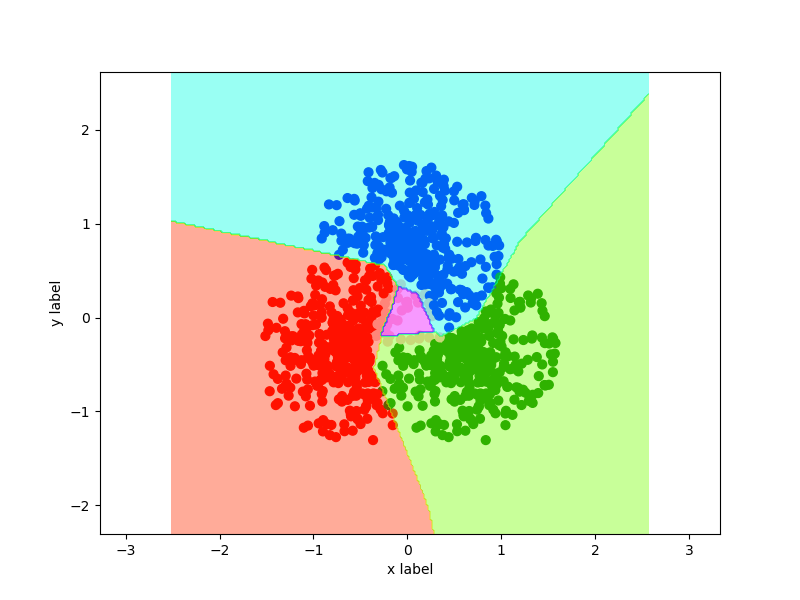

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [38]:
fig, ax = plt.subplots(figsize=(8,6)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()